In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import autoreload
import evotsc
import evotsc_plot
autoreload.reload(evotsc)
autoreload.reload(evotsc_plot)

<module 'evotsc_plot' from '/Users/theotime/Work/Code/EvoTSC/evotsc_plot.py'>

In [8]:
## Constants
# Population
nb_indivs = 100
nb_genes = 60

# Genome
intergene = 1000
interaction_dist = 2500
interaction_coef = 0.3
sigma_basal = -0.06
sigma_opt = -0.06
epsilon = 0.03
delta = 1
substeps = 2
default_basal_expression = 0.5
nb_eval_steps = 51

# Environment
sigma_A = 0.1
sigma_B = -0.1

# Mutations
inversion_poisson_lam = 2.0
intergene_poisson_lam = 0.0 #2.0
intergene_mutation_var = 0.0 #1e1
basal_sc_mutation_prob = 0.0 #1e-1
basal_sc_mutation_var = 0.0 #1e-4


In [9]:
def plot_expr(indiv, sigma_env, plot_title, plot_name):
    
    dpi = 300

    # Plot only environment A
    (temporal_expr, _), fitness = indiv.evaluate(sigma_env, sigma_env)

    nb_genes, nb_steps = temporal_expr.shape

    colors = mpl.cm.get_cmap('viridis', nb_genes)(range(nb_genes))

    plt.figure(figsize=(9, 5), dpi=dpi)

    plt.ylim(-0.05, 1.05)

    for gene in range(nb_genes):
        linestyle = 'solid' if indiv.genes[gene].orientation == 0 else 'dashed'
        plt.plot(temporal_expr[indiv.genes[gene].id, :],
                 linestyle=linestyle,
                 color=colors[indiv.genes[gene].id],
                 label=f'Gene {indiv.genes[gene].id}')

    plt.grid(linestyle=':')
    plt.xlabel('Time', fontsize='large')
    plt.ylabel('Expression level', fontsize='large')

    plt.title(plot_title + f' fitness: {fitness:.5}')


    plt.tight_layout()
    plt.savefig(plot_name, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [10]:
def plot_genome(indiv, print_ids=False, name=None):

    # Compute gene positions
    gene_pos = np.zeros(len(indiv.genes), dtype=int)
    cur_pos = 0

    for i_gene, gene in enumerate(indiv.genes):
        gene_pos[i_gene] = cur_pos
        cur_pos += gene.intergene
        #print(f'Position gène {i_gene}: {cur_pos}')
    genome_length = cur_pos

    # Plot
    fig, ax = plt.subplots(figsize=(9,9), dpi=dpi)

    rect_width = 0.04
    rect_height = 0.1

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    circle = plt.Circle(xy=(0, 0), radius=1, linestyle='-', fill=False)
    ax.add_patch(circle)
    ax.set_axis_off()


    #colors = ['tab:blue', 'tab:red', 'tab:green'] # AB: blue, A: red, B: green
    colors = mpl.cm.get_cmap('viridis', nb_genes)(range(nb_genes))
    labels = ['AB', 'A', 'B']

    for i_gene, gene in enumerate(indiv.genes):
        pos_angle = 360 * gene_pos[i_gene] / genome_length
        orient_angle = 360 - pos_angle
        pos_rad = np.radians(pos_angle)
        orient_rad = np.radians(orient_angle)

        ## Plot the gene rectangle

        x0 = (1.0 - rect_height / 2.0) * np.sin(pos_rad)
        y0 = (1.0 - rect_height / 2.0) * np.cos(pos_rad)


        if gene.orientation == 0:
            final_width = rect_width
        else:
            final_width = -rect_width


        rect = plt.Rectangle(xy=(x0, y0),
                             width=final_width,
                             height=rect_height,
                             angle=orient_angle, #in degrees anti-clockwise about xy.
                             facecolor=colors[gene.id],
                             edgecolor='black',
                             label=f'Gene {i_gene}')

        ax.add_patch(rect)

        ## Plot the orientation bar and arrow

        # Bar
        x_lin = (1.0 + (np.array([0.5, 1.0])) * rect_height) * np.sin(pos_rad)
        y_lin = (1.0 + (np.array([0.5, 1.0])) * rect_height) * np.cos(pos_rad)

        plt.plot(x_lin, y_lin, color='black', linewidth=1)

        # Arrow
        dx_arr = rect_width * np.cos(pos_rad) / 3.0
        dy_arr = - rect_width * np.sin(pos_rad) / 3.0

        if gene.orientation == 1: # Reverse
            dx_arr, dy_arr = -dx_arr, -dy_arr

        plt.arrow(x_lin[1], y_lin[1], dx_arr, dy_arr, head_width=0.02, color='black')

        ## Print gene ID
        if print_ids and (i_gene % 5 == 0):
            ha = 'left'
            if gene.orientation == 1:
                ha = 'right'
            plt.text(x=0.92*x0, y=0.92*y0, s=f'{i_gene}', rotation=orient_angle, ha=ha, va='bottom',
                     rotation_mode='anchor')


    ## Legend
    patches = [mpl.patches.Patch(facecolor=color, edgecolor='black', label=label)
               for color, label in zip(colors, labels)]
    plt.legend(handles=patches, title='Gene type', loc='center')

    line_len = np.pi*indiv.interaction_dist/genome_length
    line_y = -0.3
    plt.plot([-line_len, line_len], [line_y, line_y],
             color='black',
             linewidth=1)
    plt.text(0, line_y - 0.07, 'Gene interaction distance', ha='center')

    if name:
        plt.savefig(name, dpi=300, bbox_inches='tight')

    plt.show()

    plt.close()


In [11]:
init_genes = evotsc.Gene.generate(intergene=intergene,
                                  nb_genes=nb_genes,
                                  default_basal_expression=default_basal_expression)

In [12]:
init_indiv = evotsc.Individual(genes=init_genes,
                               interaction_dist=interaction_dist,
                               interaction_coef=interaction_coef,
                               nb_eval_steps=nb_eval_steps,
                               sigma_basal=sigma_basal,
                               sigma_opt=sigma_opt,
                               epsilon=epsilon,
                               delta=delta,
                               substeps=substeps)

In [13]:
mutation = evotsc.Mutation(basal_sc_mutation_prob=basal_sc_mutation_prob,
                           basal_sc_mutation_var=basal_sc_mutation_var,
                           intergene_poisson_lam=intergene_poisson_lam,
                           intergene_mutation_var=intergene_mutation_var,
                           inversion_poisson_lam=inversion_poisson_lam)

In [ ]:
plot_genome(init_indiv

In [74]:
nb_muts = 100

In [77]:
for i in range(nb_muts):
    init_indiv.mutate(mutation)

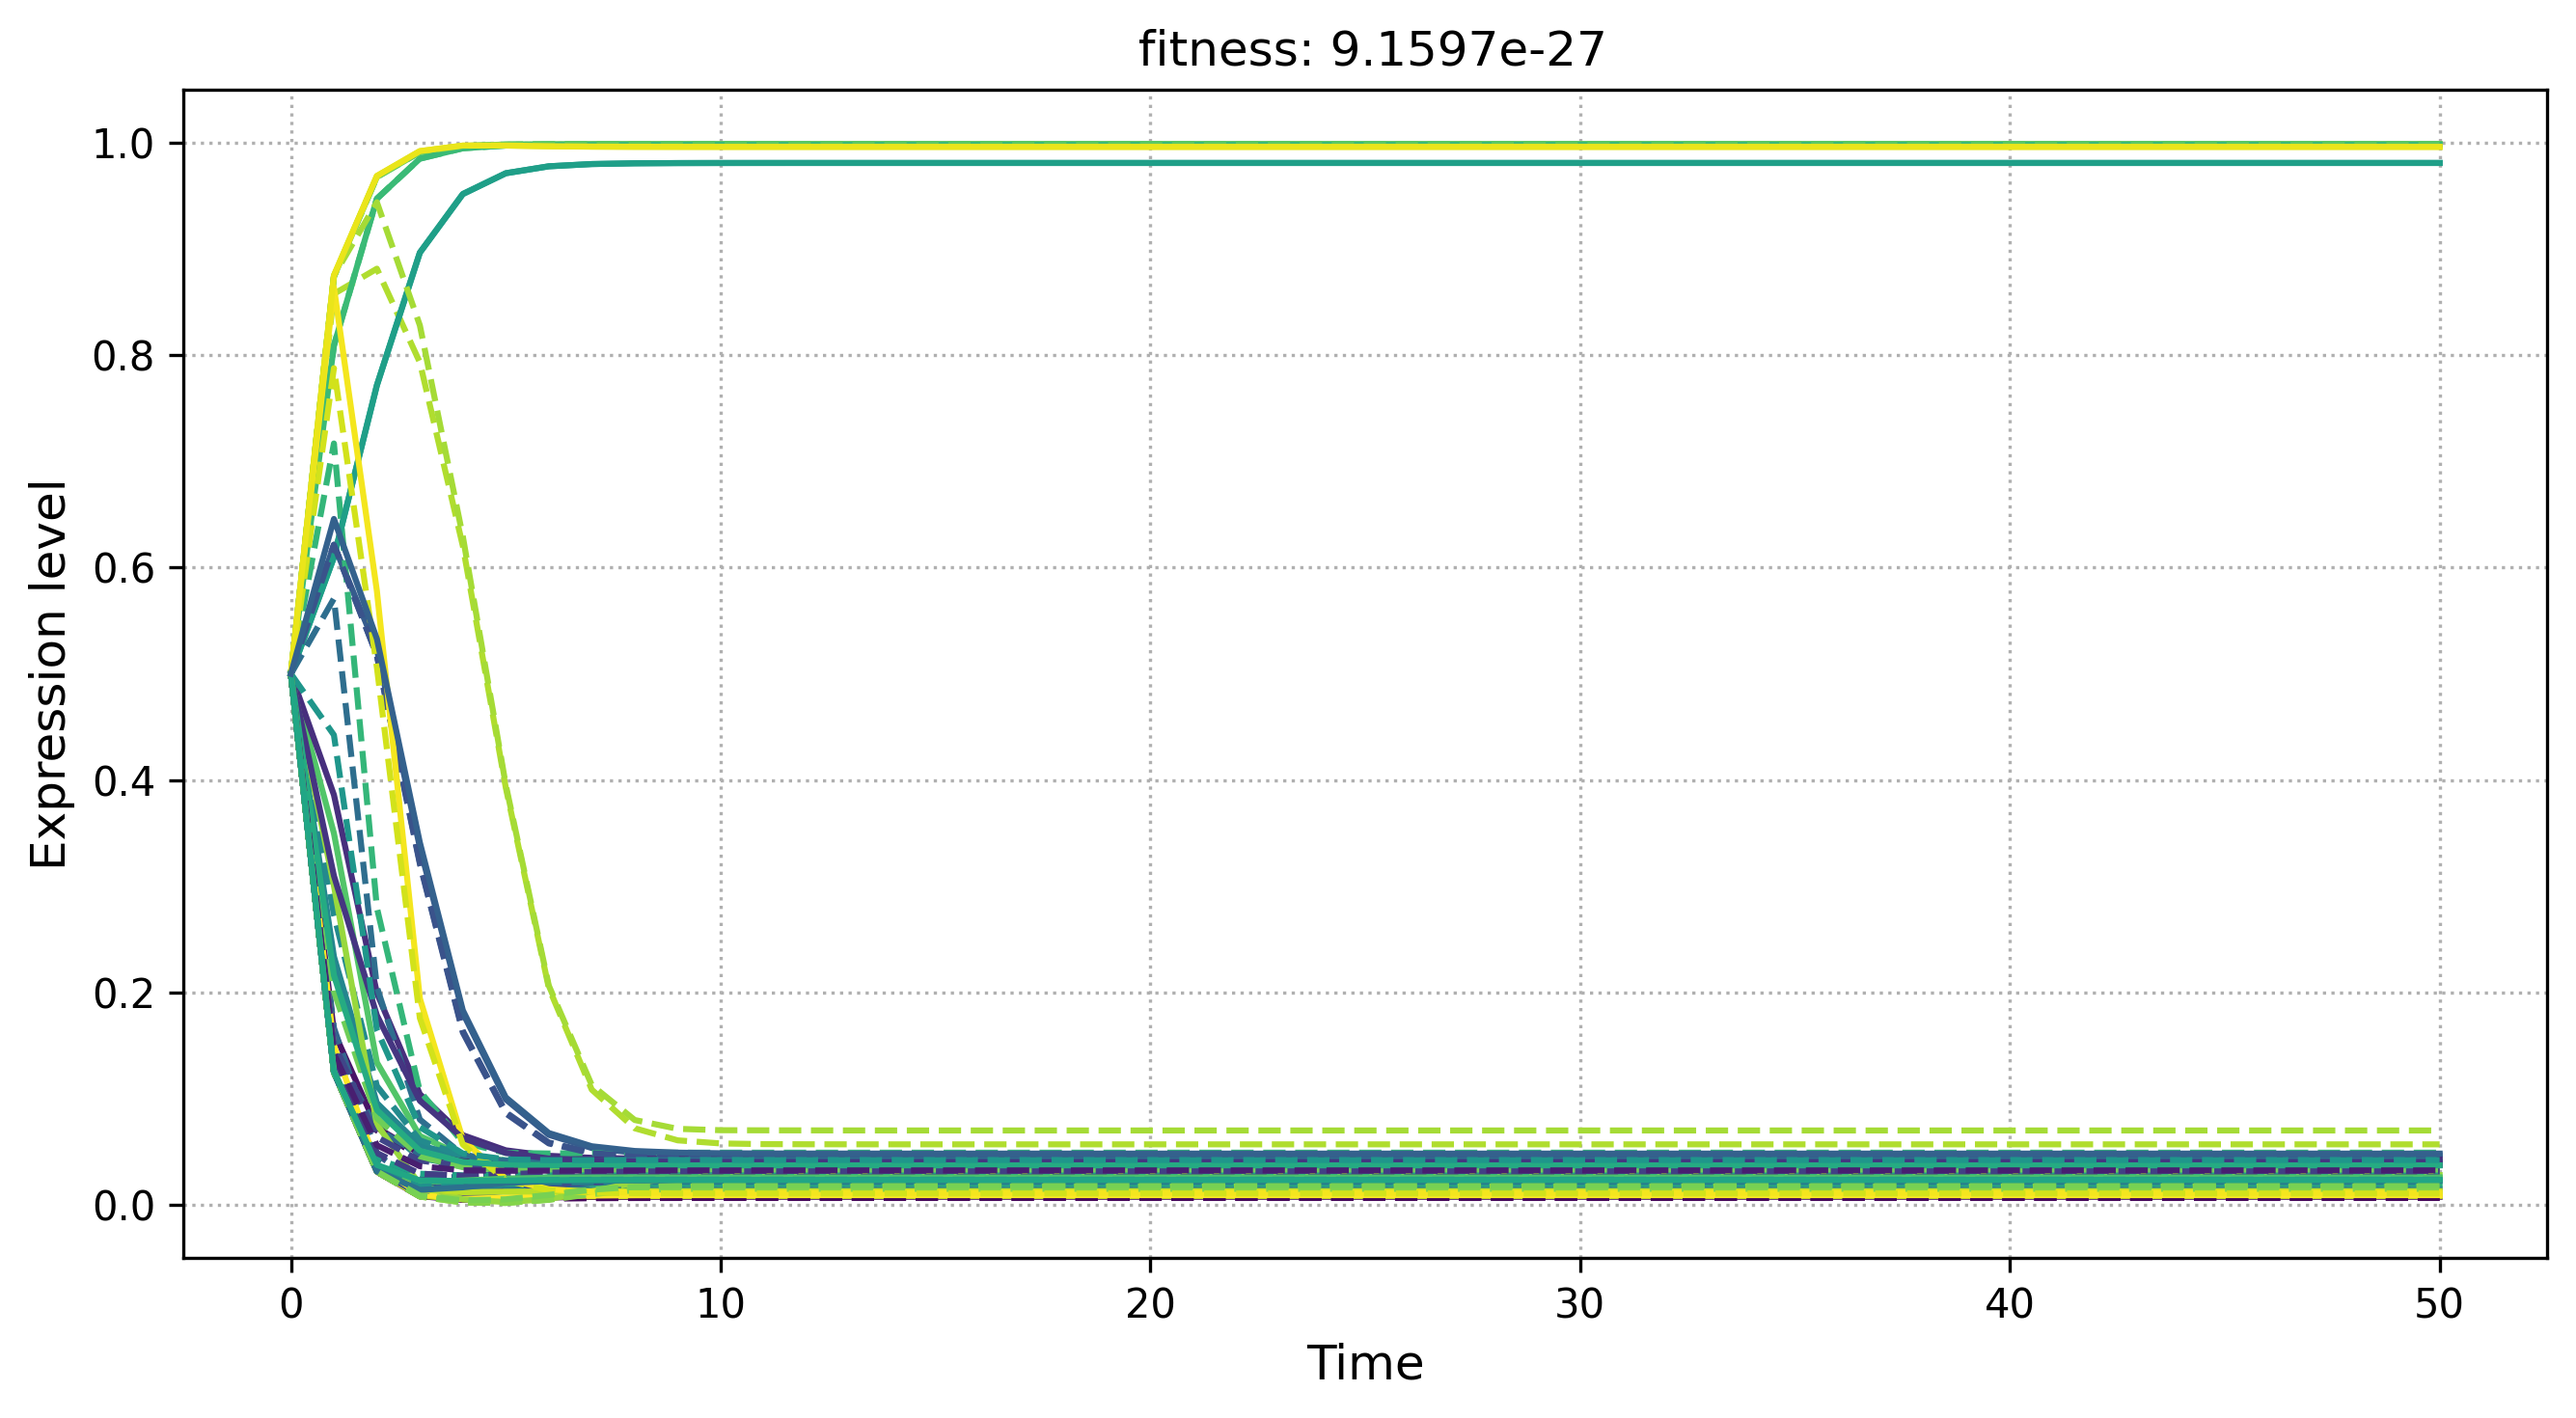

In [78]:
plot_expr(init_indiv, sigma_env=sigma_A, plot_title='', plot_name='truc')